In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
dataset = pd.read_csv('../save/data_bc_fisrt_addattr_scraped_alldates.csv')
dataset.shape

(3651248, 201)

In [3]:
dataste = dataset.sample(frac=0.1)

In [3]:
#dataset.drop(columns=['days_from_scraped'],inplace=True)

In [4]:
# Separate training and test data
ids = dataset.id.unique()
np.random.shuffle(ids)
ids_train = ids[:int(0.8 * len(ids))]
ids_test = ids[int(0.8 * len(ids)):]
dataset_train = dataset[dataset['id'].isin(ids_train)].drop(columns='id')
dataset_test = dataset[dataset['id'].isin(ids_test)].drop(columns='id')

In [5]:
# Get features and target
x_train = dataset_train.drop(columns = 'price').values
y_train = np.log(dataset_train['price'].values)

x_test = dataset_test.drop(columns = 'price').values
y_test = np.log(dataset_test['price'].values)

In [6]:
# dtrain = xgb.DMatrix('./data/agaricus.txt.train')
# dtest = xgb.DMatrix('./data/agaricus.txt.test')
dtrain = xgb.DMatrix(x_train[:], label=y_train)
dtest = xgb.DMatrix(x_test[:], label=y_test)
# specify parameters via map
param = {'max_depth':15, 'eta':0.3, 'lambda':1, 
         'silent':1, 'objective':'reg:linear', 
         #'tree_method':'gpu_hist', 
         'eval_metric':'rmse'}
num_round = 20
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

In [7]:
metrics.median_absolute_error(np.exp(y_test), np.exp(preds))

23.36180114746093

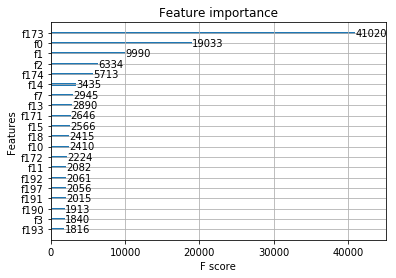

In [8]:
ax = xgb.plot_importance(bst, max_num_features = 20)

In [15]:
bst.feature_importances_

AttributeError: 'Booster' object has no attribute 'feature_importances_'

In [9]:
impfeatures = [int(str(x).split('\'')[1][1:]) for x in ax.get_yticklabels()]
impfeatures.reverse()
cols = list(dataset_train.columns.values)
cols.remove('price')
for i in impfeatures: print(i,cols[i])

173 days_from_scraped
0 host_since
1 latitude
2 longitude
174 FriSat
14 first_review
7 cleaning_fee
13 availability_365
171 polarity
15 last_review
18 number_of_reviews
10 availability_30
172 subjectivity
11 availability_60
192 Aug
197 2018
191 Jul
190 Jun
3 accommodates
193 Sep


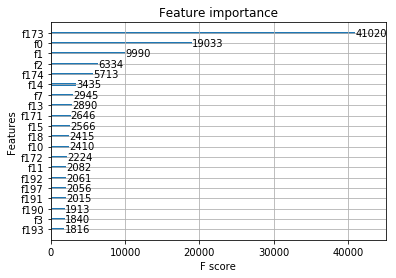

In [17]:
ax = xgb.plot_importance(bst, max_num_features = 20)

In [22]:
dir(bst)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_validate_features',
 'attr',
 'attributes',
 'best_iteration',
 'best_ntree_limit',
 'boost',
 'booster',
 'copy',
 'dump_model',
 'eval',
 'eval_set',
 'feature_names',
 'feature_types',
 'get_dump',
 'get_fscore',
 'get_score',
 'get_split_value_histogram',
 'handle',
 'load_model',
 'load_rabit_checkpoint',
 'predict',
 'save_model',
 'save_rabit_checkpoint',
 'save_raw',
 'set_attr',
 'set_param',
 'trees_to_dataframe',
 'update']

In [38]:
sorted(bst.get_score().items(), key=lambda x: x[1],reverse=True)[:20]

[('f173', 41020),
 ('f0', 19033),
 ('f1', 9990),
 ('f2', 6334),
 ('f174', 5713),
 ('f14', 3435),
 ('f7', 2945),
 ('f13', 2890),
 ('f171', 2646),
 ('f15', 2566),
 ('f18', 2415),
 ('f10', 2410),
 ('f172', 2224),
 ('f11', 2082),
 ('f192', 2061),
 ('f197', 2056),
 ('f191', 2015),
 ('f190', 1913),
 ('f3', 1840),
 ('f193', 1816)]

In [80]:
df_f = pd.DataFrame(sorted(bst.get_fscore().items(), key=lambda x: x[1],reverse=True)[:20]).set_index([0])

In [82]:
fmax = df_f.max()
df_f = df_f/fmax

In [83]:
df_f.reset_index(inplace=True)

In [84]:
df_f['features']=df_f.apply(lambda x: cols[int(x[0][1:])] , axis=1)

In [86]:
print(df_f)

       0         1           features
0   f173  1.000000  days_from_scraped
1     f0  0.463993         host_since
2     f1  0.243540           latitude
3     f2  0.154412          longitude
4   f174  0.139274             FriSat
5    f14  0.083740       first_review
6     f7  0.071794       cleaning_fee
7    f13  0.070453   availability_365
8   f171  0.064505           polarity
9    f15  0.062555        last_review
10   f18  0.058874  number_of_reviews
11   f10  0.058752    availability_30
12  f172  0.054217       subjectivity
13   f11  0.050756    availability_60
14  f192  0.050244                Aug
15  f197  0.050122               2018
16  f191  0.049122                Jul
17  f190  0.046636                Jun
18    f3  0.044856       accommodates
19  f193  0.044271                Sep
